<a href="https://colab.research.google.com/github/Priyo-prog/Time-series-analysis/blob/main/Business%20Case/volkswagen_buyout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Business Case : Volkswagen buyout of Porsche**

## Pip Install

In [1]:
!pip3 install numpy scipy patsy pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip3 install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [4]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 903 kB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 32.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [5]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.3 MB/s 


Delete the "!pip uninstall statsmodels" once the installation is complete

## Import the Packages and Libraries

In [6]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import yfinance # yahoo finanace
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Importing the Data

In [7]:
raw_data = yfinance.download(tickers="VOW3.DE, PAH3.DE, BMW.DE", interval="1d", group_by="ticker",
                             auto_adjust=True, treads=True)

[*********************100%***********************]  3 of 3 completed


In [8]:
df = raw_data.copy()

## Defining Key Dates

In [9]:
## Starting Date
start_date = '2009-04-05'

## First Official Announcement - 49.9%
ann_1 = '2009-12-09'

## Second Official Announcement - 50.1%
ann_2 = '2012-07-05'

## Ending Date
end_date = '2014-01-01'

## Dieselgate scanndal
d_gate = '2015-09-20'

## Pre-processing the Data

In [10]:
## Extracting Closing Prices
df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

## Creating Returns (We'll be examimng volatility)
df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

## Creating Squared Returns
df['sq_vol'] = df.ret_vol.mul(df.ret_vol)
df['sq_por'] = df.ret_por.mul(df.ret_por)
df['sq_bmw'] = df.ret_bmw.mul(df.ret_bmw)

## Extracting Volume (Quantity extracted on that day)
df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume

In [11]:
## Assigning the frequency and Filling NA Values
df = df.asfreq('b')
df = df.fillna(method='bfill')

In [12]:
## Removing Surplus Data
del df['VOW3.DE'], df['PAH3.DE'], df['BMW.DE']

In [13]:
df.head()

,vol,por,bmw,ret_vol,ret_por,ret_bmw,sq_vol,sq_por,sq_bmw,q_vol,q_por,q_bmw
,,,,,,,,,,,,
Date,,,,,,,,,,,,
1996-11-08,32.022869,25.59683,9.333746,-4.405634,-3.831324,-0.269670,19.409613,14.679047,0.072722,56336.0,901566.0,767000.0
1996-11-11,32.022869,25.59683,9.308576,-4.405634,-3.831324,-0.269670,19.409613,14.679047,0.072722,56336.0,901566.0,260000.0
1996-11-12,32.022869,25.59683,9.378949,-4.405634,-3.831324,0.756008,19.409613,14.679047,0.571547,56336.0,901566.0,1066000.0
1996-11-13,32.022869,25.59683,9.364053,-4.405634,-3.831324,-0.158828,19.409613,14.679047,0.025226,56336.0,901566.0,793000.0
1996-11-14,32.022869,25.59683,9.394359,-4.405634,-3.831324,0.323640,19.409613,14.679047,0.104743,56336.0,901566.0,351000.0


We are not splitting the data in Training and Testing set we're examining a specific event in time, rather than trying to predict the future.

## Plotting the Prices

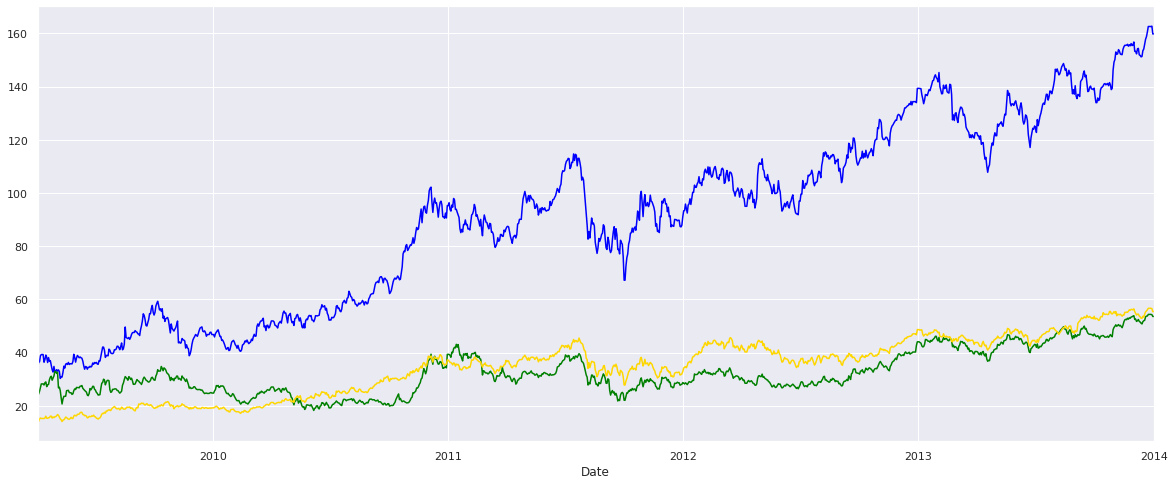

In [14]:
df['vol'][start_date:end_date].plot(figsize=(20,8), color="blue")
df['por'][start_date:end_date].plot(color="green")
df['bmw'][start_date:end_date].plot(color="gold")
plt.show()

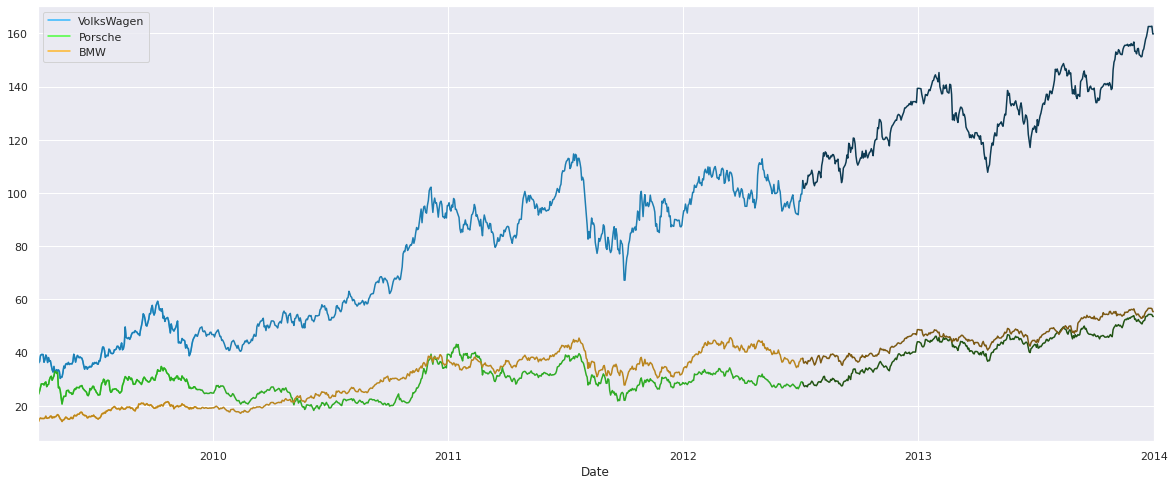

In [15]:
df['vol'][start_date:ann_1].plot(figsize=(20,8), color="#33B8FF")
df['por'][start_date:ann_1].plot(color="#49FF3A")
df['bmw'][start_date:ann_1].plot(color="#FEB628")

df['vol'][start_date:ann_2].plot(color="#1E7EB2")
df['por'][start_date:ann_2].plot(color="#2FAB25")
df['bmw'][start_date:ann_2].plot(color="#BA861F")


df['vol'][ann_2:end_date].plot(color="#0E3A52")
df['por'][ann_2:end_date].plot(color="#225414")
df['bmw'][ann_2:end_date].plot(color="#7C5913")
plt.legend(['VolksWagen', 'Porsche', 'BMW'])
plt.show()

## Correlation

In [16]:
print('Correlations among manufacturers from ' + str(start_date) + 'to' +str(end_date)+ '\n')
print('VolksWagen and Porsche correlation:\t'+ str(df['vol'][start_date:end_date].corr(df['por'][start_date:end_date])))
print('VolksWagen and BMW correlation: \t'+ str(df['vol'][start_date:end_date].corr(df['bmw'][start_date:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:end_date].corr(df['bmw'][start_date:end_date])))

Correlations among manufacturers from 2009-04-05to2014-01-01

VolksWagen and Porsche correlation:	0.835954714073849
VolksWagen and BMW correlation: 	0.979937821308389
Porsche and BMW correlation: 		0.8052157915976439


By the end of the time VW acquires 100% of Porsche, therefore the correlation should have been much higher.

In [17]:
print('Correlations among manufacturers from ' + str(start_date) + 'to' +str(ann_1)+ '\n')
print('VolksWagen and Porsche correlation:\t'+ str(df['vol'][start_date:ann_1].corr(df['por'][start_date:ann_1])))
print('VolksWagen and BMW correlation: \t'+ str(df['vol'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))

Correlations among manufacturers from 2009-04-05to2009-12-09

VolksWagen and Porsche correlation:	0.6633583944458766
VolksWagen and BMW correlation: 	0.842760825275331
Porsche and BMW correlation: 		0.6095038588003966


In [18]:
print('Correlations among manufacturers from ' + str(ann_1) + 'to' +str(ann_2)+ '\n')
print('VolksWagen and Porsche correlation:\t'+ str(df['vol'][ann_1:ann_2].corr(df['por'][ann_1:ann_2])))
print('VolksWagen and BMW correlation: \t'+ str(df['vol'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))

Correlations among manufacturers from 2009-12-09to2012-07-05

VolksWagen and Porsche correlation:	0.7428268034748786
VolksWagen and BMW correlation: 	0.9795942982842033
Porsche and BMW correlation: 		0.7042723371704382


In [19]:
print('Correlations among manufacturers from ' + str(ann_2) + 'to' +str(end_date)+ '\n')
print('VolksWagen and Porsche correlation:\t'+ str(df['vol'][ann_2:end_date].corr(df['por'][ann_2:end_date])))
print('VolksWagen and BMW correlation: \t'+ str(df['vol'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))

Correlations among manufacturers from 2012-07-05to2014-01-01

VolksWagen and Porsche correlation:	0.9405236963369273
VolksWagen and BMW correlation: 	0.9284447116721886
Porsche and BMW correlation: 		0.9494111397288065


In [20]:
print('Correlations among manufacturers from ' + str(end_date) + 'to' +str(df.index[-1])+ '\n')
print('VolksWagen and Porsche correlation:\t'+ str(df['vol'][end_date:].corr(df['por'][end_date:])))
print('VolksWagen and BMW correlation: \t'+ str(df['vol'][end_date:].corr(df['bmw'][end_date:])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][end_date:].corr(df['bmw'][end_date:])))

Correlations among manufacturers from 2014-01-01to2022-08-08 00:00:00

VolksWagen and Porsche correlation:	0.8924973981752915
VolksWagen and BMW correlation: 	0.6821158731681864
Porsche and BMW correlation: 		0.782573214520028


## Best Fitting Models

### For VolksWagen

In [21]:
mod_pr_pre_vol = auto_arima(df.vol[start_date:ann_1], exogenus=df[['por', 'bmw']][start_date:ann_1],
                            m=5, max_p=5, max_q=5)
mod_pr_btn_vol = auto_arima(df.vol[start_date:ann_1], exogenus=df[['por', 'bmw']][ann_1:ann_2],
                            m=5, max_p=5, max_q=5)
mod_pr_post_vol = auto_arima(df.vol[start_date:ann_1], exogenus=df[['por', 'bmw']][ann_2:end_date],
                            m=5, max_p=5, max_q=5)

In [22]:
print(mod_pr_pre_vol.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -325.261
Date:                Mon, 08 Aug 2022   AIC                            652.523
Time:                        14:23:42   BIC                            655.699
Sample:                             0   HQIC                           653.811
                                - 178                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.3103      0.128     17.983      0.000       2.059       2.562
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):               232.52
Prob(Q):                              0.62   Pr

In [23]:
print(mod_pr_btn_vol.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -325.261
Date:                Mon, 08 Aug 2022   AIC                            652.523
Time:                        14:23:42   BIC                            655.699
Sample:                             0   HQIC                           653.811
                                - 178                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.3103      0.128     17.983      0.000       2.059       2.562
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):               232.52
Prob(Q):                              0.62   Pr

In [24]:
print(mod_pr_post_vol.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -325.261
Date:                Mon, 08 Aug 2022   AIC                            652.523
Time:                        14:23:43   BIC                            655.699
Sample:                             0   HQIC                           653.811
                                - 178                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.3103      0.128     17.983      0.000       2.059       2.562
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):               232.52
Prob(Q):                              0.62   Pr

### For Porsche

In [25]:
mod_pr_pre_por = auto_arima(df.por[start_date:ann_1], exogenus=df[['vol', 'bmw']][start_date:ann_1],
                            m=5, max_p=5, max_q=5)
mod_pr_btn_por = auto_arima(df.por[start_date:ann_1], exogenus=df[['vol', 'bmw']][ann_1:ann_2],
                            m=5, max_p=5, max_q=5)
mod_pr_post_por = auto_arima(df.por[start_date:ann_1], exogenus=df[['vol', 'bmw']][ann_2:end_date],
                             m=5, max_p=5, max_q=5)

In [26]:
print(mod_pr_pre_por.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -251.149
Date:                Mon, 08 Aug 2022   AIC                            504.298
Time:                        14:25:33   BIC                            507.474
Sample:                             0   HQIC                           505.586
                                - 178                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.0000      0.053     19.004      0.000       0.897       1.103
Ljung-Box (L1) (Q):                   3.50   Jarque-Bera (JB):               319.80
Prob(Q):                              0.06   Pr

In [27]:
print(mod_pr_btn_por.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -251.149
Date:                Mon, 08 Aug 2022   AIC                            504.298
Time:                        14:25:48   BIC                            507.474
Sample:                             0   HQIC                           505.586
                                - 178                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.0000      0.053     19.004      0.000       0.897       1.103
Ljung-Box (L1) (Q):                   3.50   Jarque-Bera (JB):               319.80
Prob(Q):                              0.06   Pr

In [28]:
print(mod_pr_post_por.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -251.149
Date:                Mon, 08 Aug 2022   AIC                            504.298
Time:                        14:26:10   BIC                            507.474
Sample:                             0   HQIC                           505.586
                                - 178                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.0000      0.053     19.004      0.000       0.897       1.103
Ljung-Box (L1) (Q):                   3.50   Jarque-Bera (JB):               319.80
Prob(Q):                              0.06   Pr

### For BMW

In [29]:
mod_pr_pre_bmw = auto_arima(df.bmw[start_date:ann_1], exogenus=df[['vol', 'por']][start_date:ann_1],
                            m=5, max_p=5, max_q=5)
mod_pr_btn_bmw = auto_arima(df.bmw[start_date:ann_1], exogenus=df[['vol', 'por']][ann_1:ann_2],
                            m=5, max_p=5, max_q=5)
mod_pr_post_bmw = auto_arima(df.bmw[start_date:ann_1], exogenus=df[['vol', 'por']][ann_2:end_date],
                             m=5, max_p=5, max_q=5)

In [30]:
print(mod_pr_pre_bmw.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -93.020
Date:                Mon, 08 Aug 2022   AIC                            188.040
Time:                        14:31:20   BIC                            191.216
Sample:                             0   HQIC                           189.328
                                - 178                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1675      0.016     10.355      0.000       0.136       0.199
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                 1.73
Prob(Q):                              0.57   Pr

In [31]:
print(mod_pr_btn_bmw.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -93.020
Date:                Mon, 08 Aug 2022   AIC                            188.040
Time:                        14:31:22   BIC                            191.216
Sample:                             0   HQIC                           189.328
                                - 178                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1675      0.016     10.355      0.000       0.136       0.199
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                 1.73
Prob(Q):                              0.57   Pr

In [32]:
print(mod_pr_post_bmw.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -93.020
Date:                Mon, 08 Aug 2022   AIC                            188.040
Time:                        14:31:22   BIC                            191.216
Sample:                             0   HQIC                           189.328
                                - 178                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1675      0.016     10.355      0.000       0.136       0.199
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                 1.73
Prob(Q):                              0.57   Pr

## Predictions for the Future

Take the best fitting model and forecast them into the future.

Compare the predictions (based on data before the announcement) to the actual values following it.

Now : VolksWagen after the first announcement

HW : 1) Volkswagen after the 2nd announcement

2) VolksWagen after Diselgate

### For Porsche

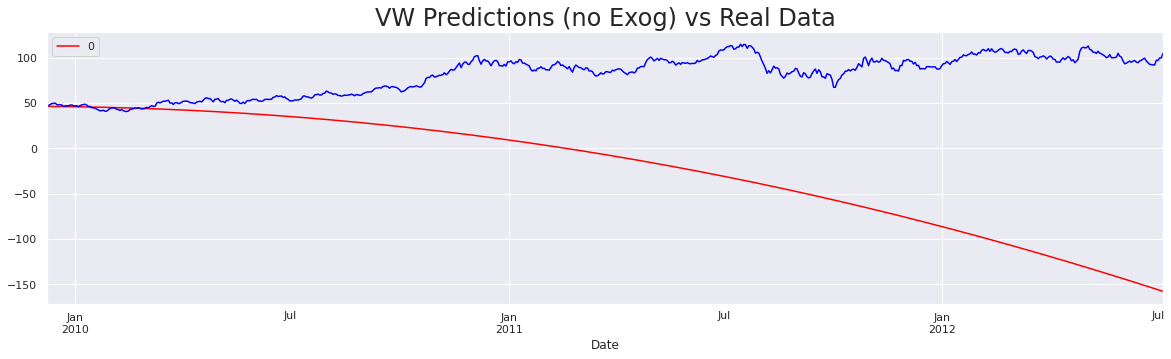

In [34]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], m=5, max_p=5, max_q=5,
                              max_P=5, max_Q=5, trend='ct')

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods=len(df[ann_1:ann_2])), index=df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize=(20,5), color='red')

df.vol[ann_1:ann_2].plot(color='blue')
plt.title("VW Predictions (no Exog) vs Real Data", size=24)
plt.show()

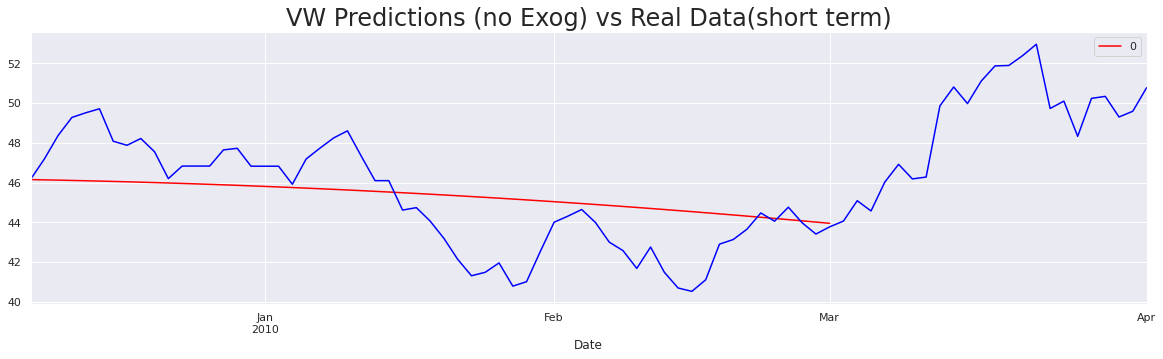

In [42]:
df_auto_pred_pr[ann_1:'2010-03-01'].plot(figsize=(20,5), color='red')
df.vol[ann_1:'2010-04-01'].plot(color='blue')
plt.title("VW Predictions (no Exog) vs Real Data(short term)", size=24)
plt.show()

### For VolksWagen

In [43]:
model_auto_pred_pr = auto_arima(df.vol[start_date:ann_1], m=5, max_p=5, max_q=5,
                                exogenous=df[['por']][start_date:ann_1],
                              max_P=5, max_Q=5, trend='ct')

df_auto_pred_pr = pd.DataFrame(model_auto_pred_pr.predict(n_periods=len(df[ann_1:ann_2])),
                               exogenous=df[['por']][ann_1:ann_2],
                               index=df[ann_1:ann_2].index)
df_auto_pred_pr[ann_1:ann_2].plot(figsize=(20,5), color='red')

df.vol[ann_1:ann_2].plot(color='blue')
plt.title("VW Predictions (no Exog) vs Real Data", size=24)
plt.show()

ValueError: ignored